# Проект: Построение ML-модели для предсказания температуры сплава

Для оптимизации производственных расходов, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 
Наша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Цель проекта:** Построить модель, которая будет предсказывать температуру сплава.

**План проекта:**
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

**Описание данных:**
Данные состоят из нескольких файлов, полученных из разных источников:

1. Файл **data_arc_new.csv** — данные об электродах;
    - ***key*** — номер партии;
    - ***Начало нагрева дугой*** — время начала нагрева;
    - ***Конец нагрева дугой*** — время окончания нагрева;
    - ***Активная мощность*** — значение активной мощности;
    - ***Реактивная мощность*** — значение реактивной мощности.


2. Файл **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
    - ***key*** — номер партии;
    - ***Bulk 1 … Bulk 15*** — объём подаваемого материала.
    
    
3. Файл **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
    - ***key*** — номер партии;
    - ***Bulk 1 … Bulk 15*** — время подачи материала.


4. Файл **data_gas_new.csv** — данные о продувке сплава газом;
    - ***key*** — номер партии;
    - ***Газ 1*** — объём подаваемого газа.


5. Файл **data_temp_new.csv** — результаты измерения температуры;
    - ***key*** — номер партии;
    - ***Время замера*** — время замера;
    - ***Температура*** — значение температуры.


6. Файл **data_wire_new.csv** — данные о проволочных материалах (объём);
    - ***key*** — номер партии;
    - ***Wire 1 … Wire 9*** — объём подаваемых проволочных материалов.


7. Файл **data_wire_time_new.csv** — данные о проволочных материалах (время).
    - ***key*** — номер партии;
    - ***Wire 1 … Wire 9*** — время подачи проволочных материалов.


## Загрузка данных

Загрузим данные и выполним их первичный осмотр.

### Импорт библиотек

In [1]:
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time
import warnings
warnings.filterwarnings('ignore')

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance

### Ввод констант

In [3]:
RANDOM_STATE = 210425
TEST_SIZE = 0.25

###  Загрузка данных

In [4]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [5]:
def general_info_data(df):
    display(df.head())
    display(df.info())
    print(f"\033[1m Пропуски в данных: \033[0m")
    display(df.isna().sum())
    print(f"\033[1m Проверка на дубликаты: \033[0m")
    display(df.duplicated().sum())

In [6]:
list_data = [data_arc, 
             data_bulk, 
             data_bulk_time,
             data_gas,
             data_temp, 
             data_wire,
             data_wire_time]

list_name = ['Данные об электродах', 
             'Данные о подаче сыпучих материалов (объём)',
             'Данные о подаче сыпучих материалов (время)', 
             'Данные о продувке сплава газом', 
             'Результаты измерения температуры', 
             'Данные о проволочных материалах (объём)', 
             'Данные о проволочных материалах (время)']

In [7]:
for i,j in zip(list_data, list_name):
    print(f"\033[1m{j}:\033[0m")
    general_info_data(i)
    print()
    print()
    print()

Данные об электродах:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

 Пропуски в данных: 


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

 Проверка на дубликаты: 


0




Данные о подаче сыпучих материалов (объём):


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

 Пропуски в данных: 


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

 Проверка на дубликаты: 


0




Данные о подаче сыпучих материалов (время):


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

 Пропуски в данных: 


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

 Проверка на дубликаты: 


0




Данные о продувке сплава газом:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

 Пропуски в данных: 


key      0
Газ 1    0
dtype: int64

 Проверка на дубликаты: 


0




Результаты измерения температуры:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

 Пропуски в данных: 


key                0
Время замера       0
Температура     3427
dtype: int64

 Проверка на дубликаты: 


0




Данные о проволочных материалах (объём):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

 Пропуски в данных: 


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

 Проверка на дубликаты: 


0




Данные о проволочных материалах (время):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

 Пропуски в данных: 


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

 Проверка на дубликаты: 


0

**ВЫВОД:**

Данные состоят из нескольких файлов, полученных из разных источников:

1. Данные об электродах:
    - датафрейм содержит 14876 строк;
    - пропусков нет;
    - дубликатов нет;
    - наименования столбцов необходимо привести к нижнему регистру, змеиный стиль, используем латиницу;
    - тип данных столбцов Начало/Конец нагрева дугой - object, необходимо привести к типу даты pandas.


2. Данные о подаче сыпучих материалов (объём, время):
    - датафрейм содержит 3129 строк;
    - есть пропуски в данных;
    - дубликатов нет;
    - наименования столбцов необходимо привести к нижнему регистру, змеиному стилю.
    
    
3. Данные о продувке сплава газом:
    - датафрейм содержит 3239 строк;
    - пропусков нет;
    - дубликатов нет;
    - тип данных корректный.
    

4. Результаты измерения температуры:
    - датафрейм содержит 18092 строк;
    - 3427 пропусков в замерах температуры;
    - тип данных столца Время замера - object, необходимо привести к типу даты pandas.
    

5. Данные о проволочных материалах (объём, время).
    - датафрейм содержит 3081 строку;
    - есть пропуски в данных;
    - дубликатов нет.


## Исследовательский анализ и предобработка данных

Выполним исследовательский анализ каждого датафрейма и предобработку. Оценим имеющиеся признаки: понадобятся ли они для обучения моделей. Рассмотрим необходимость генерации новых признаков.

### *Данные об электродах*

Переименуем столбцы:

In [8]:
data_arc.columns = ['key', 'start_arc_heating', 'finish_arc_heating', 'active_power', 'reactive_power']

In [9]:
data_arc.head(2)

,key,start_arc_heating,finish_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


Приведем к типу даты pandas тип данных столбцов Начало/Конец нагрева дугой

In [10]:
data_arc['start_arc_heating'] =pd.to_datetime(data_arc['start_arc_heating'], format = '%Y-%m-%d %H:%M:%S')
data_arc['finish_arc_heating'] =pd.to_datetime(data_arc['finish_arc_heating'], format = '%Y-%m-%d %H:%M:%S')

In [11]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   start_arc_heating   14876 non-null  datetime64[ns]
 2   finish_arc_heating  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [12]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [13]:
columns_col = ['active_power', 
               'reactive_power']

name_col = ['Активная мощность',
            'Реактивная мощность']

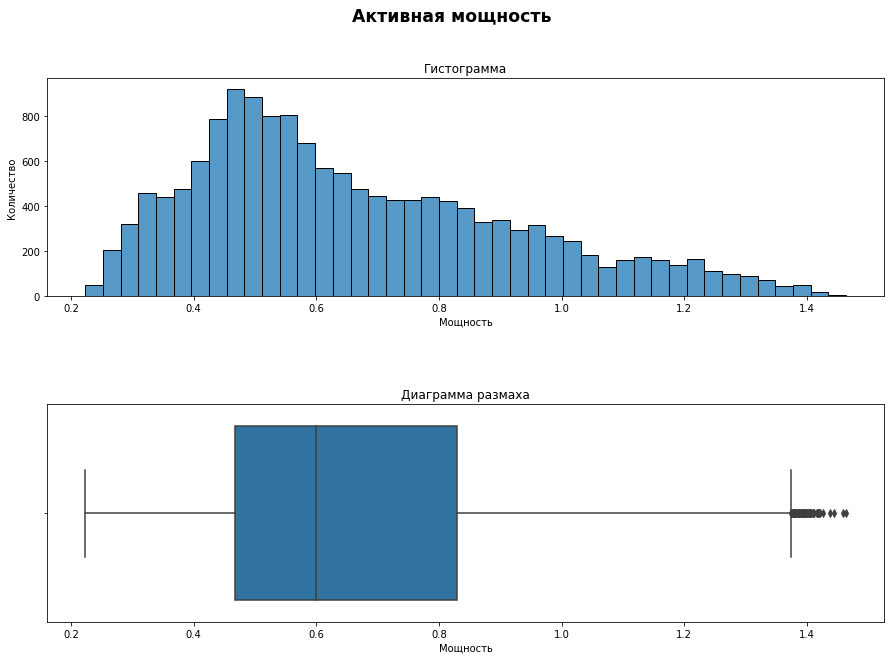

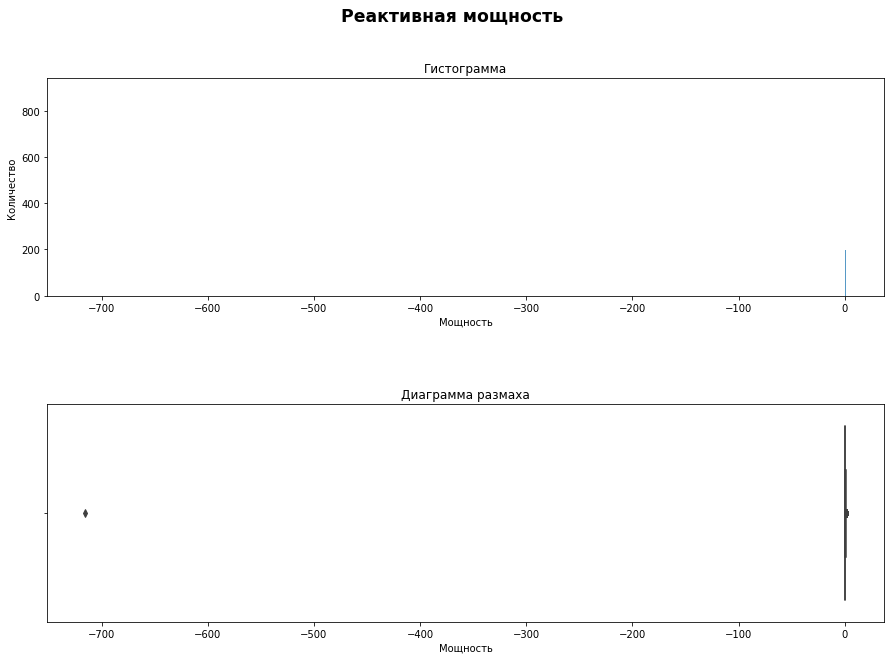

In [14]:
for i, j in zip(columns_col, name_col):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))
    
    sns.histplot(data = data_arc, x = i, ax=axs[0])
    axs[0].set_title('Гистограмма')
    axs[0].set_xlabel('Мощность')
    axs[0].set_ylabel('Количество')
    
    sns.boxplot(data = data_arc, x = i, ax=axs[1])
    axs[1].set_title('Диаграмма размаха')
    axs[1].set_xlabel('Мощность')
       
    fig.suptitle(j, fontsize = 'xx-large', fontweight = 600)
    plt.subplots_adjust(hspace = 0.5)
    plt.show()

В представленных данных по реактивной мощности есть супервыброс -715.479924. Уберем данные по этому ковшу из датафрейма.

In [15]:
data_arc.loc[data_arc['reactive_power'] < 0]

,key,start_arc_heating,finish_arc_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [16]:
data_arc = data_arc.loc[data_arc['key'] != 2116]

In [17]:
data_arc.shape[0]

14872

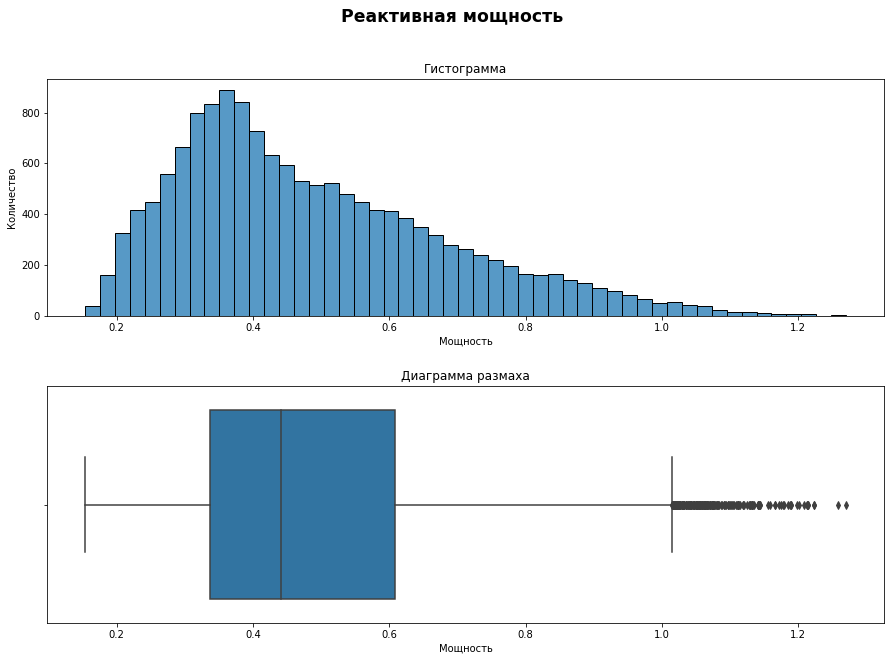

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.histplot(data = data_arc, x = 'reactive_power', ax=axs[0])
axs[0].set_title('Гистограмма')
axs[0].set_xlabel('Мощность')
axs[0].set_ylabel('Количество')
    
sns.boxplot(data = data_arc, x = 'reactive_power', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Мощность')
       
fig.suptitle('Реактивная мощность', fontsize = 'xx-large', fontweight = 600)
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [19]:
data_arc.head(2)

,key,start_arc_heating,finish_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


Добавим новый признак - длительность нагрева дугой. 

In [20]:
data_arc['total_arc_heating'] = (data_arc['finish_arc_heating'] - data_arc['start_arc_heating']).astype('timedelta64[s]')

In [21]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14872 non-null  int64         
 1   start_arc_heating   14872 non-null  datetime64[ns]
 2   finish_arc_heating  14872 non-null  datetime64[ns]
 3   active_power        14872 non-null  float64       
 4   reactive_power      14872 non-null  float64       
 5   total_arc_heating   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 813.3 KB


In [22]:
data_arc['total_arc_heating'] = data_arc['total_arc_heating'].astype(int)

Стартовые и конечные значения времени нагрева исключим из датафрейма

In [23]:
data_arc = data_arc.drop(['start_arc_heating', 'finish_arc_heating'], axis = 1 )

In [24]:
data_arc.head(10)

,key,active_power,reactive_power,total_arc_heating
0,1,0.305130,0.211253,228
1,1,0.765658,0.477438,185
2,1,0.580313,0.430460,172
3,1,0.518496,0.379979,365
4,1,0.867133,0.643691,148
5,2,0.381124,0.220351,137
6,2,0.261665,0.205527,338
7,2,0.710297,0.484962,126
8,2,0.786322,0.542517,210
9,3,1.101678,0.820856,280


In [25]:
data_arc['total_arc_heating'].describe()

count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: total_arc_heating, dtype: float64

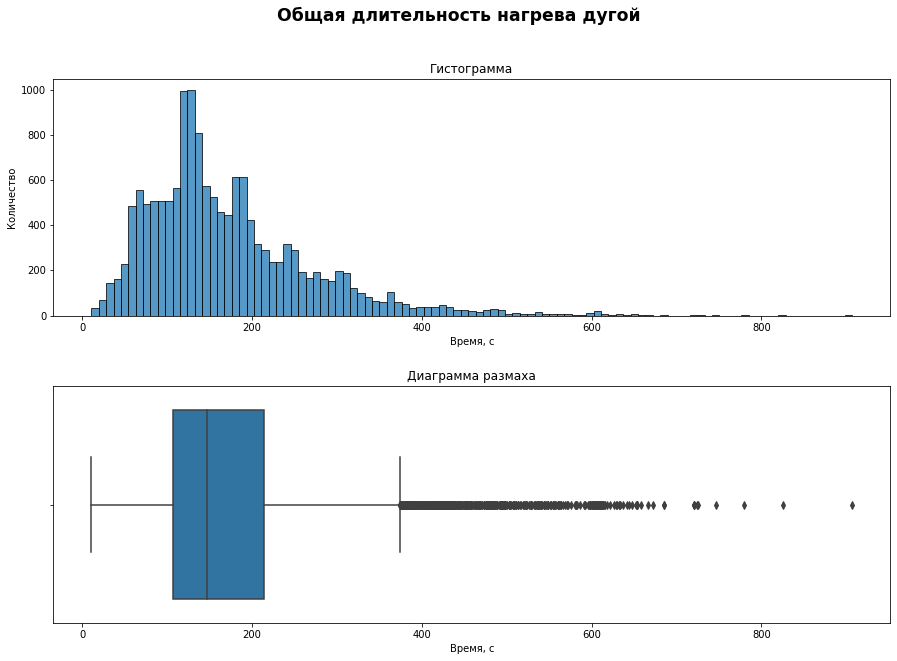

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.histplot(data = data_arc, x = 'total_arc_heating', ax=axs[0])
axs[0].set_title('Гистограмма')
axs[0].set_xlabel('Время, с')
axs[0].set_ylabel('Количество')
    
sns.boxplot(data = data_arc, x = 'total_arc_heating', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Время, с')
       
fig.suptitle('Общая длительность нагрева дугой', fontsize = 'xx-large', fontweight = 600)
plt.subplots_adjust(hspace = 0.3)
plt.show()

Оставим выбросы без изменений. Процесс легирования в некоторых случаях, в зависимости от первоначального состава сплава, может потребовать длительного приведения химического состава к нормативным значениям.

Добавим новый признак - полная мощность.

Полная мощность, равная геометрической сумме активной и реактивной мощности, выражается формулой:
S² = P² + Q².
Этот показатель дает полное представление о нагрузке в системе и помогает учитывать все аспекты энергопотребления.

In [27]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**(0.5)

In [28]:
data_arc.head(2)

,key,active_power,reactive_power,total_arc_heating,full_power
0,1,0.305130,0.211253,228,0.371123
1,1,0.765658,0.477438,185,0.902319


Сгруппируем данные по партиям:

In [29]:
data_arc = data_arc.groupby('key')[['total_arc_heating', 'active_power', 'full_power']].sum().reset_index()

In [30]:
data_arc.head(2)

,key,total_arc_heating,active_power,full_power
0,1,1098,3.036730,3.718736
1,2,811,2.139408,2.588349


In [31]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                3213 non-null   int64  
 1   total_arc_heating  3213 non-null   int64  
 2   active_power       3213 non-null   float64
 3   full_power         3213 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 100.5 KB


**ВЫВОД:** 

- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу. 
- Тип данных столбцов Начало/Конец нагрева дугой приведен к типу даты pandas.
- В представленных данных об электродах по реактивной мощности обнаружен супервыброс -715.479924. Данные по ковшу удалены из датафрейма.
- Добавлены новые признаки: длительность нагрева дугой, полная мощность.

### *Данные о подаче сыпучих материалов (объём)*

Приведем наименования колонок к нижнему регистру, змеиному стилю

In [32]:
data_bulk.columns = data_bulk.columns.str.replace(r' ', r'_').str.lower()

In [33]:
data_bulk.head(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


Пропуски в данных говорят о том, что в процессе легирования стали тот или иной вид сыпучих материалов не использовался. Укажем значение объема матерала равное 0.

In [34]:
data_bulk = data_bulk.fillna(0)

In [35]:
data_bulk.head(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


In [36]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


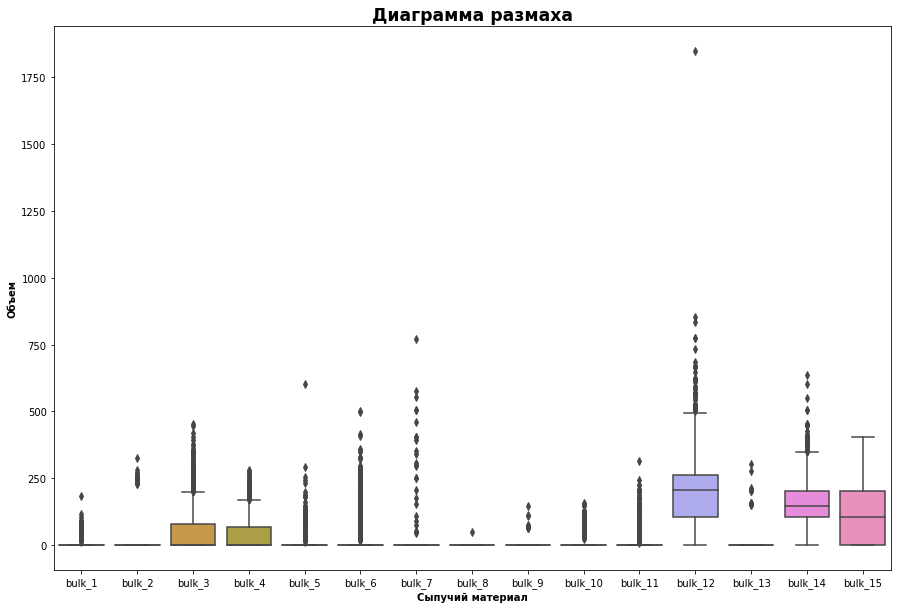

In [37]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data = data_bulk.drop('key', axis = 1))

plt.title('Диаграмма размаха', fontsize = 'xx-large', fontweight = 600)
plt.xlabel('Сыпучий материал', weight='bold')
plt.ylabel('Объем', weight='bold')
plt.show()

Обнаружен выброс в значениях объема сыпучего материала Bulk 12 - 1849. Однако, чтюбы модель была максимально близка к реальным условиям, оставим выбросы без изменений.

**ВЫВОД:** 

- Наименования столбцов привели к нижнему регистру, змеиному стилю. Пропуски заменены на "0". 
- Выбросы оставим без изменений.


### *Данные о подаче сыпучих материалов (время)*

In [38]:
data_bulk_time.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39


**ВЫВОД:** Данные этого датафрейма для построения модели не нужны.

### *Данные о продувке сплава газом*

Переименуем столбцы:

In [39]:
data_gas.columns = ['key', 'gas_1']

In [40]:
data_gas.head(2)

,key,gas_1
0,1,29.749986
1,2,12.555561


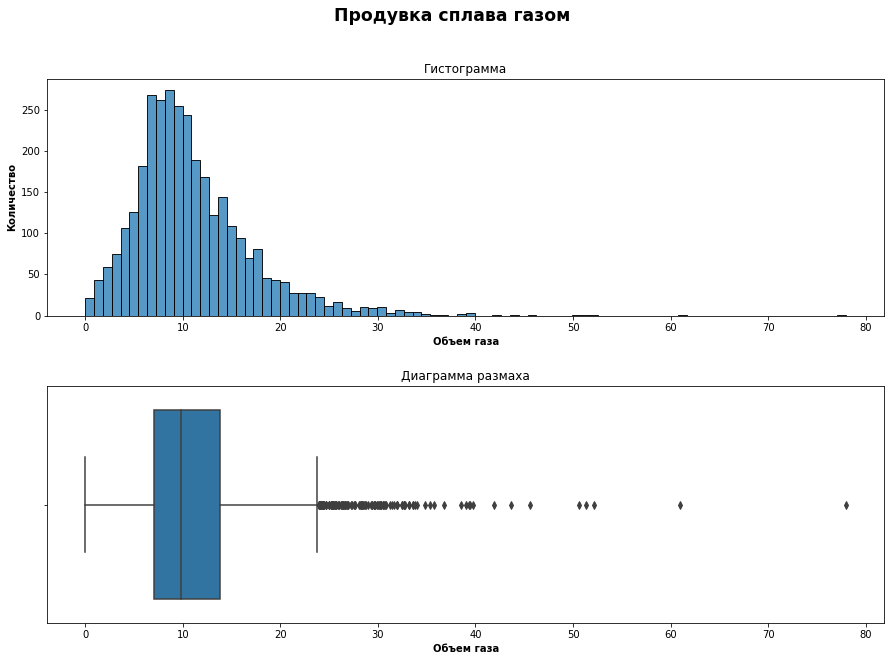

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.histplot(data = data_gas, x = 'gas_1', ax=axs[0])
axs[0].set_title('Гистограмма')
axs[0].set_xlabel('Объем газа', weight='bold')
axs[0].set_ylabel('Количество', weight='bold')
    
sns.boxplot(data = data_gas, x = 'gas_1', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Объем газа', weight='bold')
       
fig.suptitle('Продувка сплава газом', fontsize = 'xx-large', fontweight = 600)
plt.subplots_adjust(hspace = 0.3)
plt.show()

Оставим выбросы без изменений.

**ВЫВОД:** Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу.




### *Результаты измерения температуры*

Переименуем столбцы:

In [42]:
data_temp.columns = ['key', 'temp_time', 'temp']

In [43]:
data_temp.head(2)

,key,temp_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


Приведем к типу даты pandas тип данных столбца времени замера температуры

In [44]:
data_temp['temp_time'] =pd.to_datetime(data_temp['temp_time'], format = '%Y-%m-%d %H:%M:%S')

In [45]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        18092 non-null  int64         
 1   temp_time  18092 non-null  datetime64[ns]
 2   temp       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Удалим партии с пропусками.

In [46]:
temp_nan = data_temp.loc[data_temp.isna().any(axis=1)]['key'].unique().tolist()

In [47]:
data_temp = data_temp[~data_temp['key'].isin(temp_nan)]

In [48]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13926 non-null  int64         
 1   temp_time  13926 non-null  datetime64[ns]
 2   temp       13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


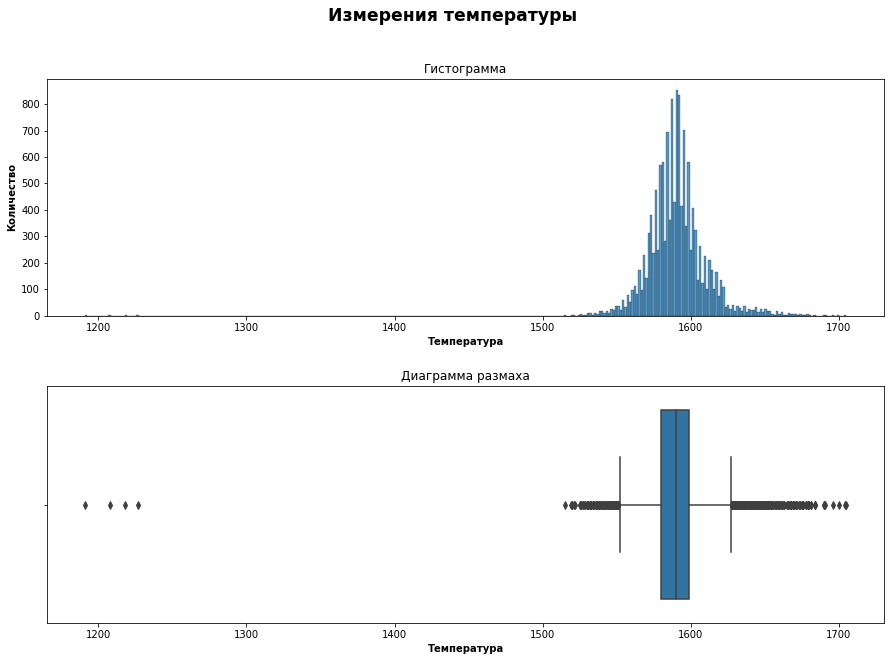

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.histplot(data = data_temp, x = 'temp', ax=axs[0])
axs[0].set_title('Гистограмма')
axs[0].set_xlabel('Температура', weight='bold')
axs[0].set_ylabel('Количество', weight='bold')
    
sns.boxplot(data = data_temp, x = 'temp', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Температура', weight='bold')
       
fig.suptitle('Измерения температуры', fontsize = 'xx-large', fontweight = 600)
plt.subplots_adjust(hspace = 0.3)
plt.show()

Обнаружены выбросы ниже температуры плавления стали (1400). Удалим данные таких партий из датафрейма.

In [50]:
temp_drop = data_temp.loc[data_temp['temp'] < 1400]['key'].tolist()

In [51]:
temp_drop

[867, 1214, 1619, 2052]

In [52]:
data_temp = data_temp[~data_temp['key'].isin(temp_drop)]

In [53]:
data_temp.shape[0]

13905

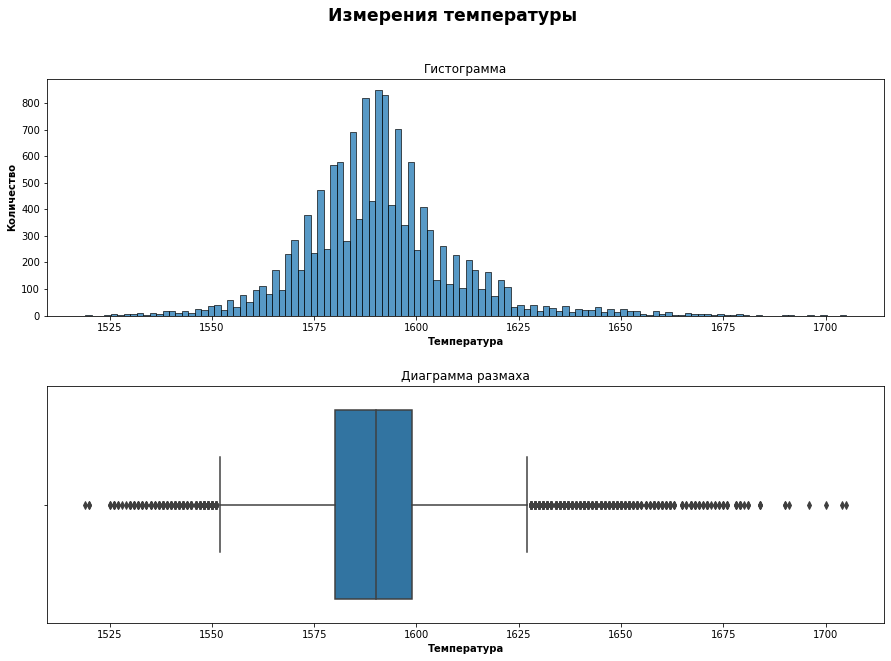

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.histplot(data = data_temp, x = 'temp', ax=axs[0])
axs[0].set_title('Гистограмма')
axs[0].set_xlabel('Температура', weight='bold')
axs[0].set_ylabel('Количество', weight='bold')
    
sns.boxplot(data = data_temp, x = 'temp', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
axs[1].set_xlabel('Температура', weight='bold')
       
fig.suptitle('Измерения температуры', fontsize = 'xx-large', fontweight = 600)
plt.subplots_adjust(hspace = 0.3)
plt.show()

В качестве целевого признака выделим значение последнего измерения температуры в партии. Так же добавим признаки - температура в начале процесса, количество измерений температур, среднее значение температур.

In [55]:
data_temp['start_temp'] = data_temp['temp']
data_temp['finish_temp'] = data_temp['temp']

In [56]:
data_temp = (
    data_temp
    .groupby('key')
    .agg({'key': 'count',
          'start_temp':'first',
          'finish_temp':'last'})
    .rename(columns={'key':'count_temp'})
    .reset_index()
)

In [57]:
data_temp.head(5)

,key,count_temp,start_temp,finish_temp
0,1,6,1571.0,1613.0
1,2,5,1581.0,1602.0
2,3,6,1596.0,1599.0
3,4,5,1601.0,1625.0
4,5,5,1576.0,1602.0


In [58]:
data_temp

,key,count_temp,start_temp,finish_temp
0,1,6,1571.0,1613.0
1,2,5,1581.0,1602.0
2,3,6,1596.0,1599.0
3,4,5,1601.0,1625.0
4,5,5,1576.0,1602.0
...,...,...,...,...
2468,2495,5,1570.0,1591.0
2469,2496,7,1554.0,1591.0
2470,2497,4,1571.0,1589.0
2471,2498,6,1591.0,1594.0


Удалим партии, в которых меньше 2 измерений: 

In [59]:
temp_drop_count = data_temp.loc[data_temp['count_temp'] < 2]['key'].tolist()

In [60]:
temp_drop_count

[195, 279]

In [61]:
data_temp = data_temp[~data_temp['key'].isin(temp_drop_count)]

In [62]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2472
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2471 non-null   int64  
 1   count_temp   2471 non-null   int64  
 2   start_temp   2471 non-null   float64
 3   finish_temp  2471 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 96.5 KB


**ВЫВОД:** 

- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу. 
- Тип данных столбца времени замера температуры приведен к типу даты pandas.
- Удалены строки с пропусками.
- Обнаружены выбросы ниже температуры плавления стали (1400). Данные таких партий удалены из датафрейма.
- Добавлены признаки начальной и конечной температур в партии.



### *Данные о проволочных материалах (объём)*

Приведем наименования колонок к нижнему регистру, змеиному стилю

In [63]:
data_wire.columns = data_wire.columns.str.replace(r' ', r'_').str.lower()

In [64]:
data_wire.head(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски в данных говорят о том, что в процессе легирования стали тот или иной вид проволочных материалов не использовался. Укажем значение объема матерала равное 0.

In [65]:
data_wire = data_wire.fillna(0)

In [66]:
data_wire.head(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


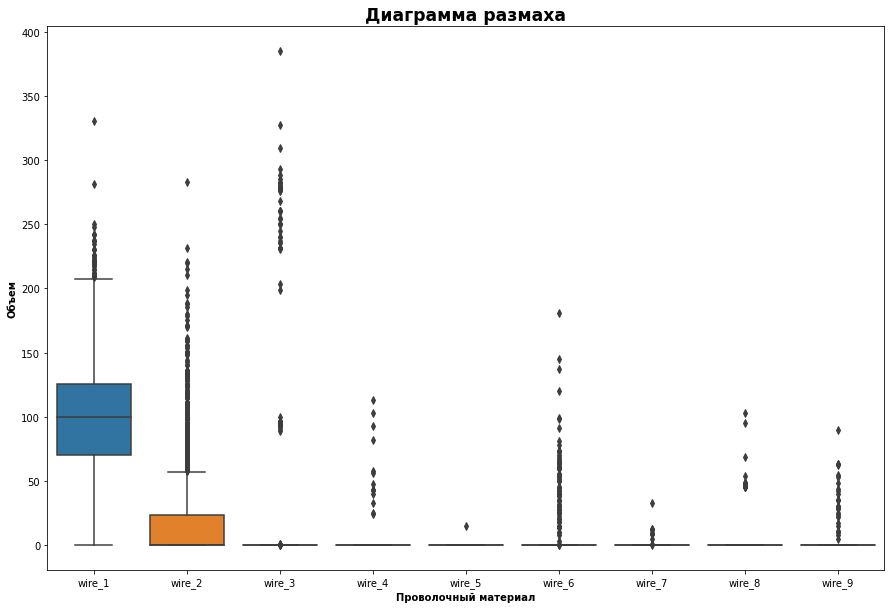

In [68]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data = data_wire.drop('key', axis = 1))

plt.title('Диаграмма размаха', fontsize = 'xx-large', fontweight = 600)
plt.xlabel('Проволочный материал', weight='bold')
plt.ylabel('Объем', weight='bold')
plt.show()

**ВЫВОД:** 

- Наименования столбцов привели к нижнему регистру, змеиному стилю. Пропуски заменены на "0". 
- Выбросы есть, но их решено оставить.


### *Данные о проволочных материалах (время)*

In [69]:
data_wire_time.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**ВЫВОД:** Данные этого датафрейма для построения модели не нужны.

**ВЫВОД:**

<u>Данные об электродах:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу;
- Тип данных столбцов Начало/Конец нагрева дугой приведен к типу даты pandas;
- В представленных данных об электродах по реактивной мощности обнаружен супервыброс -715.479924. Данные по ковшу удалены из датафрейма.
- Добавлены новые признаки: длительность нагрева дугой, полная мощность и работа.

<u>Данные о подаче сыпучих материалов (объём, время):</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю;
- Пропуски заменены на "0";
- Обнаружен выброс в значениях объема сыпучего материала Bulk 12 - 1849. Данные по партии удалены из датафрейма.
- Данные датафрейма с временем для построения модели не нужны.

<u>Данные о продувке сплава газом:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу;
- Выбросы есть, но их решено оставить.

<u>Результаты измерения температуры:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу. 
- Тип данных столбца времени замера температуры приведен к типу даты pandas.
- Удалены строки с пропусками.
- Обнаружены выбросы ниже температуры плавления стали (1400). Данные таких партий удалены из датафрейма.
- Добавлены признаки начальной и конечной температур в партии.

<u>Данные о проволочных материалах (объём, время):</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю. Пропуски заменены на "0". 
- Выбросы есть, но их решено оставить.
- Данные датафрейма с временем для построения модели не нужны.

## Объединение данных

Объединим выбранные признаки в один датафрейм по ключу. Нужны только те ключи, которые есть во всех датафреймах.

In [70]:
merged_df1 = pd.merge(data_arc, data_bulk, on='key', how='inner')
merged_df2 = pd.merge(merged_df1, data_gas, on='key', how='inner')
merged_df3 = pd.merge(merged_df2, data_temp, on='key', how='inner')
merged_data = pd.merge(merged_df3, data_wire, on='key', how='inner')

In [71]:
general_info_data(merged_data)

,key,total_arc_heating,active_power,full_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,finish_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1098,3.036730,3.718736,0.0,0.0,0.0,43.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.139408,2.588349,0.0,0.0,0.0,73.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,4.063641,5.019223,0.0,0.0,0.0,34.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,2.706489,3.400038,0.0,0.0,0.0,81.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.252950,2.816980,0.0,0.0,0.0,78.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2324 non-null   int64  
 1   total_arc_heating  2324 non-null   int64  
 2   active_power       2324 non-null   float64
 3   full_power         2324 non-null   float64
 4   bulk_1             2324 non-null   float64
 5   bulk_2             2324 non-null   float64
 6   bulk_3             2324 non-null   float64
 7   bulk_4             2324 non-null   float64
 8   bulk_5             2324 non-null   float64
 9   bulk_6             2324 non-null   float64
 10  bulk_7             2324 non-null   float64
 11  bulk_8             2324 non-null   float64
 12  bulk_9             2324 non-null   float64
 13  bulk_10            2324 non-null   float64
 14  bulk_11            2324 non-null   float64
 15  bulk_12            2324 non-null   float64
 16  bulk_13            2324 

None

 Пропуски в данных: 


key                  0
total_arc_heating    0
active_power         0
full_power           0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas_1                0
count_temp           0
start_temp           0
finish_temp          0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
dtype: int64

 Проверка на дубликаты: 


0

## Исследовательский анализ и предобработка данных объединённого датафрейма

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков, выполним предобработку. Проведем корреляционный анализ.

In [72]:
merged_data.set_index('key', inplace=True)

In [73]:
phik_overview = phik_matrix(merged_data, interval_cols=merged_data.columns)

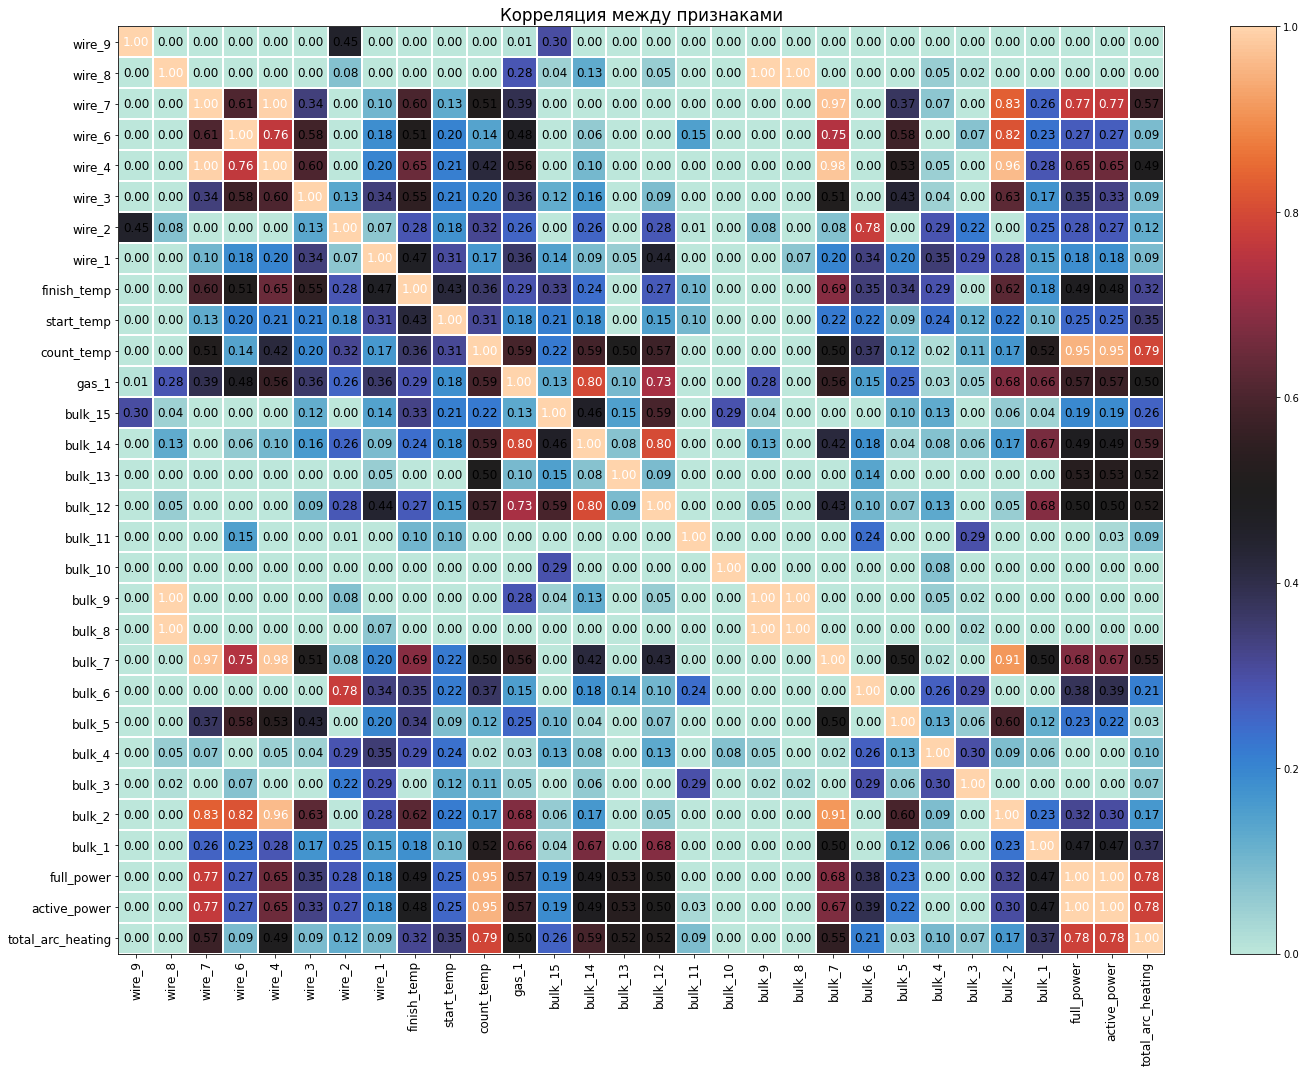

In [74]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='icefire',
    title=r'Корреляция между признаками',
    fontsize_factor=1.2,
    figsize=(20,15)
) 

Удалим признаки с очень слабой корреляцией с целевым признаком.

In [75]:
data = merged_data.drop(
    [
        'wire_4',
        'wire_3',
        'bulk_7',
        'wire_8',
        'bulk_2',
        'bulk_14',
        'wire_5',
        'bulk_3',
        'bulk_5',
        'bulk_8',
        'bulk_9',
        'bulk_10',
        'bulk_11',
        'bulk_13',
        'wire_9',
    ],
    axis=1,
)

In [76]:
phik_overview = phik_matrix(data, interval_cols=data.columns)

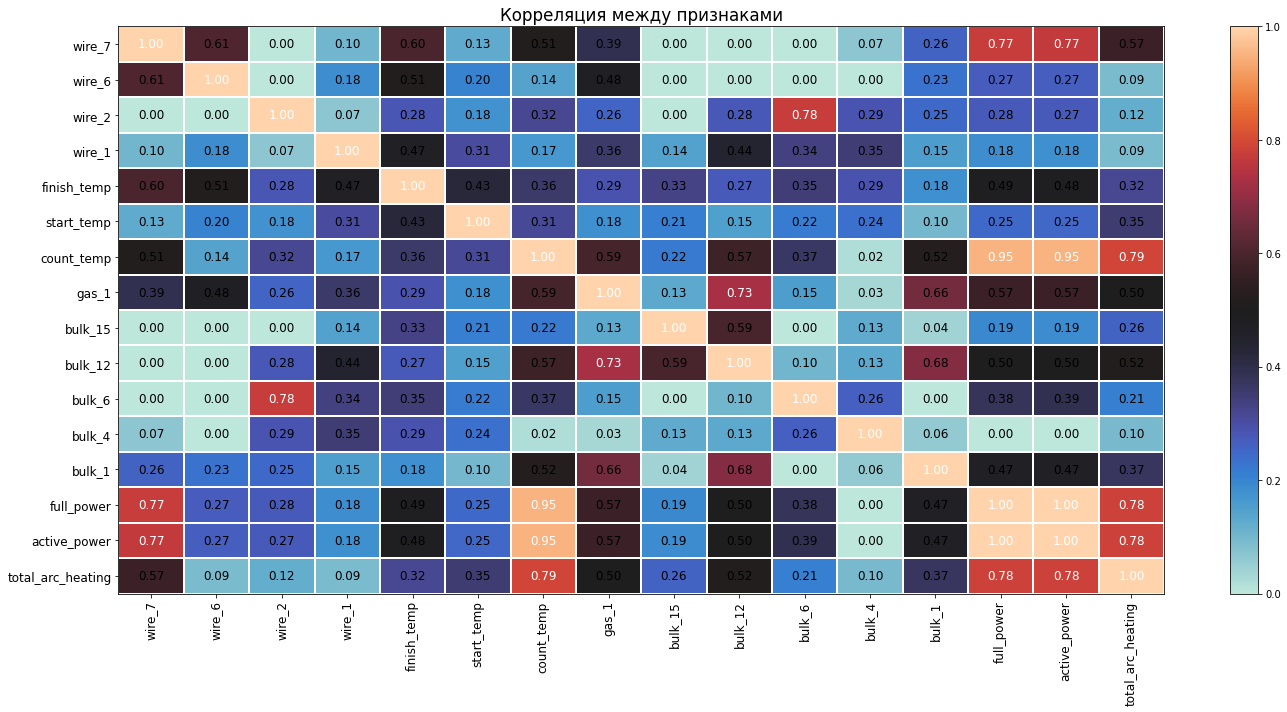

In [77]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='icefire',
    title=r'Корреляция между признаками',
    fontsize_factor=1.2,
    figsize=(20,10)
) 

**ВЫВОД:**

- Удалены факторы, у которых отсутствует корреляция с целевым признаком.

In [78]:
data

,total_arc_heating,active_power,full_power,bulk_1,bulk_4,bulk_6,bulk_12,bulk_15,gas_1,count_temp,start_temp,finish_temp,wire_1,wire_2,wire_6,wire_7
key,,,,,,,,,,,,,,,,
1,1098,3.036730,3.718736,0.0,43.0,0.0,206.0,154.0,29.749986,6,1571.0,1613.0,60.059998,0.00000,0.0,0.0
2,811,2.139408,2.588349,0.0,73.0,0.0,206.0,154.0,12.555561,5,1581.0,1602.0,96.052315,0.00000,0.0,0.0
3,655,4.063641,5.019223,0.0,34.0,0.0,205.0,153.0,28.554793,6,1596.0,1599.0,91.160157,0.00000,0.0,0.0
4,741,2.706489,3.400038,0.0,81.0,0.0,207.0,154.0,18.841219,5,1601.0,1625.0,89.063515,0.00000,0.0,0.0
5,869,2.252950,2.816980,0.0,78.0,0.0,203.0,152.0,5.413692,5,1576.0,1602.0,89.238236,9.11456,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,723,3.168133,3.868721,0.0,0.0,0.0,256.0,223.0,7.125735,5,1570.0,1591.0,89.150879,0.00000,0.0,0.0
2496,940,4.174918,5.070316,0.0,63.0,0.0,256.0,226.0,9.412616,7,1554.0,1591.0,114.179527,0.00000,0.0,0.0
2497,569,3.605239,4.360918,0.0,85.0,0.0,230.0,226.0,6.271699,4,1571.0,1589.0,94.086723,9.04800,0.0,0.0


In [79]:
data.loc[3000:3000]

,total_arc_heating,active_power,full_power,bulk_1,bulk_4,bulk_6,bulk_12,bulk_15,gas_1,count_temp,start_temp,finish_temp,wire_1,wire_2,wire_6,wire_7
key,,,,,,,,,,,,,,,,


## Подготовка данных

Выполним подготовку данных для обучения модели. Разделим данные на две выборки, при масштабировании и кодировании учтем особенности данных и моделей.

In [80]:
features = data.drop('finish_temp', axis=1)
target = data['finish_temp']

In [81]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE) 

In [82]:
display(features_train.shape)
display(features_test.shape)

(1743, 15)

(581, 15)

In [83]:
scaler = StandardScaler()

features_train_scaler = scaler.fit_transform(features_train)
features_train_scaler = pd.DataFrame(features_train_scaler, columns=features_train.columns)

**ВЫВОД:**

- Данные разделены на тренировочную и тестовую выборки.

## Обучение моделей машинного обучения

### Модель LinearRegression

In [84]:
%%time

model_lr = LinearRegression()

mae_lr = (cross_val_score(model_lr,
                          X=features_train_scaler,
                          y=target_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')).mean().round(1)*(-1)

print('Средняя оценка качества модели:', mae_lr)
print()

Средняя оценка качества модели: 6.3

CPU times: user 80 ms, sys: 48.1 ms, total: 128 ms
Wall time: 42.7 ms


### Модель RandomForestRegressor

In [85]:
%%time

model_rfc = RandomForestRegressor()

params_rfr = {'n_estimators': [10, 50, 100],
              'max_depth': [5, 10, 20, 30, 50],
              'min_samples_split': [3, 4, 5],
              'bootstrap': [True, False],
              'random_state': [RANDOM_STATE]}
    
clf = GridSearchCV(model_rfc, 
                   params_rfr, 
                   scoring='neg_mean_absolute_error',
                   cv=5)

clf.fit(features_train, target_train)

mae_rfr = (clf.best_score_*(-1)).round(1)

print('Лучшие параметры:', clf.best_params_)
print()
print('Лучшая оценка качества модели:', mae_rfr)
print()

Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 210425}

Лучшая оценка качества модели: 6.3

CPU times: user 4min 38s, sys: 581 ms, total: 4min 38s
Wall time: 4min 41s


### Модель CatBoostRegressor

In [86]:
%%time

model_cbr = CatBoostRegressor() 
param_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
              'random_state':[RANDOM_STATE],
              'verbose':[False]}]

clf = GridSearchCV(model_cbr, 
                   param_cbr, 
                   scoring='neg_mean_absolute_error')

clf.fit(features_train, target_train)

mae_cbr = (clf.best_score_*(-1)).round(1)

print('Лучшие параметры:', clf.best_params_)
print()
print('Лучшая оценка качества модели:', mae_cbr)
print()

Лучшие параметры: {'learning_rate': 0.1, 'random_state': 210425, 'verbose': False}

Лучшая оценка качества модели: 6.5

CPU times: user 42.1 s, sys: 1.81 s, total: 43.9 s
Wall time: 1min 3s


## Выбор лучшей модели

Выберите лучшую модель и проверьте её качество на тестовой выборке.

### Анализ LinearRegression

In [87]:
%%time
start = time.time()

model_lr = LinearRegression() 

model_lr.fit(features_train_scaler, target_train)

finish = time.time()
time_lr=round(finish-start,2)

CPU times: user 7.4 ms, sys: 46 µs, total: 7.44 ms
Wall time: 4.49 ms


In [88]:
%%time
start = time.time()

pred_lr = model_lr.predict(features_train_scaler)

finish = time.time()
time_lr_pred=round(finish-start,2)

CPU times: user 32.9 ms, sys: 27.8 ms, total: 60.8 ms
Wall time: 13.5 ms


### Анализ RandomForestRegressor

In [89]:
%%time
start = time.time()

model_rfr = RandomForestRegressor(bootstrap = True,
                                  max_depth = 10,
                                  min_samples_split = 3,
                                  n_estimators = 100,
                                  random_state = RANDOM_STATE)

model_rfr.fit(features_train, target_train)

finish = time.time()
time_rfr=round(finish-start,2)

CPU times: user 1.17 s, sys: 28.3 ms, total: 1.2 s
Wall time: 2.05 s


In [90]:
%%time
start = time.time()

pred_rfr = model_rfr.predict(features_train)

finish = time.time()
time_rfr_pred=round(finish-start,2)

CPU times: user 36.7 ms, sys: 8 µs, total: 36.7 ms
Wall time: 43.1 ms


### Анализ CatBoostRegressor

In [91]:
%%time
start = time.time()

model_cbr = CatBoostRegressor(learning_rate = 0.1, 
                              random_state = RANDOM_STATE, 
                              verbose = False) 
model_cbr.fit(features_train, target_train)

finish = time.time()
time_cbr=round(finish-start,2)

CPU times: user 2.69 s, sys: 145 ms, total: 2.84 s
Wall time: 4.66 s


In [92]:
%%time
start = time.time()

pred_cbr = model_cbr.predict(features_train)

finish = time.time()
time_cbr_pred=round(finish-start,2)

CPU times: user 5.29 ms, sys: 0 ns, total: 5.29 ms
Wall time: 4.09 ms


### Сравнение моделей

In [93]:
model_analysis = pd.DataFrame(index = ['LinearRegression',
                                       'RandomForestRegressor',
                                       'CatBoostRegressor'],
                              columns = ['MAE',
                                         'Prediction time',
                                         'Training time',])

In [94]:
model_analysis['MAE'] = (mae_lr,
                         mae_rfr,
                         mae_cbr)
model_analysis['Prediction time'] = (time_lr_pred,
                                    time_rfr_pred,
                                    time_cbr_pred)
model_analysis['Training time'] = (time_lr,
                                   time_rfr,
                                   time_cbr)

In [95]:
model_analysis.sort_values(by = ['MAE', 'Prediction time', 'Training time'])

,MAE,Prediction time,Training time
LinearRegression,6.3,0.01,0.00
RandomForestRegressor,6.3,0.04,2.05
CatBoostRegressor,6.5,0.00,4.66


### Оценка лучшей модели на тестовой выборке

In [96]:
best_model_pred = model_rfr.predict(features_test)
best_model_mae = mean_absolute_error(target_test, best_model_pred)
print('Качество лучшей модели на тестовой выборке:\n','MAE = ', round(best_model_mae, 1))

Качество лучшей модели на тестовой выборке:
 MAE =  6.1


**ВЫВОД:** 

Наименьшее значения метрики MAE показали модели LinearRegression и RandomForestRegressor, однако, оценка лучшей модели на тестовой выборке показала, что метрика МАЕ модели LinearRegression не удовлетворяет требованию добиться МАЕ не больше 6,8. Модель CatBoostRegressor показала наибольшие значение МАЕ и время обучения.

Метрика MAE лучшей модели RandomForestRegressor на тестовой выборке 6.1, что удовлетворяет требованию при постановке задачи: добиться МАЕ не больше 6,8.

Рассмотрим график важности признаков на графике:

In [97]:
coef = model_rfr.feature_importances_

In [98]:
for i, importance in enumerate(coef):
    print('feature', i+1, 'importance:', importance)

feature 1 importance: 0.22897987532954922
feature 2 importance: 0.0257674908846961
feature 3 importance: 0.025092056310906018
feature 4 importance: 0.016926351999217992
feature 5 importance: 0.016200127297585003
feature 6 importance: 0.07573128034248681
feature 7 importance: 0.04476887119938488
feature 8 importance: 0.039334352256702926
feature 9 importance: 0.06314400218767907
feature 10 importance: 0.021215789953018906
feature 11 importance: 0.23490517083033746
feature 12 importance: 0.12395183611088066
feature 13 importance: 0.052248701130114504
feature 14 importance: 0.025658438201156753
feature 15 importance: 0.0060756559662836695


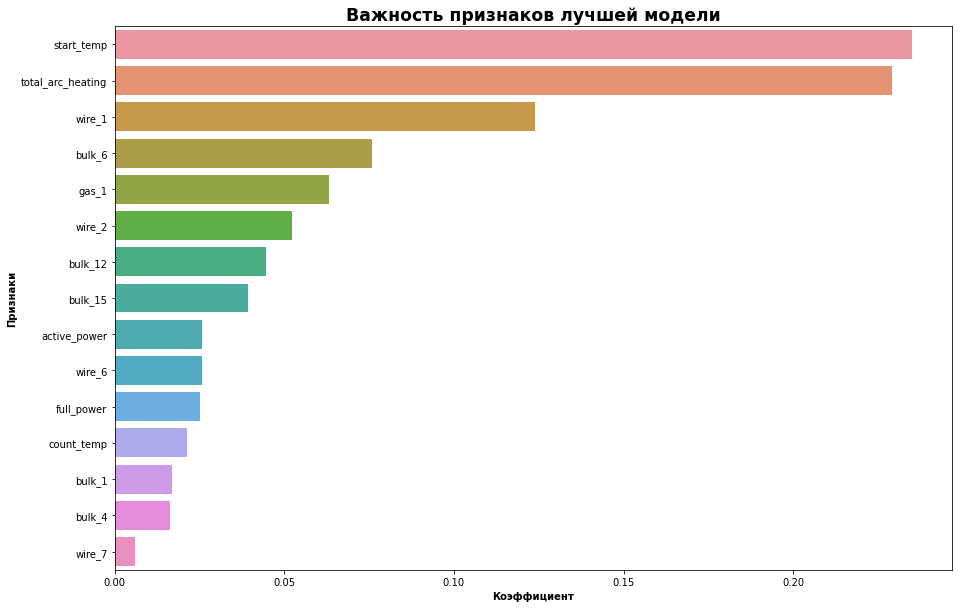

In [99]:
feature_importance = (pd.DataFrame({'feature': features_test.columns,
                                    'importance': np.abs(coef)})
                     ).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(data=feature_importance,
            x='importance',
            y='feature')

plt.title('Важность признаков лучшей модели', fontsize = 'xx-large', fontweight = 600)
plt.xlabel('Коэффициент', weight='bold')
plt.ylabel('Признаки', weight='bold')
plt.show()


**ВЫВОД:**

Наиболее значимыми являются признаки:
- Начальная температура;
- Длительность нагрева дугой.

Далее по значимости:
- Объем проволочных материалов (1, 2);
- Объем сыпучих материалов (6, 12, 15);
- Объем продувки газом сплава.
- Активная мощность;
- Объем проволочных материалов (6);
- Полная мощность;
- Количество измерений

Наименее значимы:
- Объем сыпучих материалов (1, 4);
- Объем проволочных материалов (7)



## Общий вывод и рекомендации заказчику

**АНАЛИЗ ОБЩЕЙ ИНФОРМАЦИИ:**

Данные состоят из нескольких файлов, полученных из разных источников:

1. Данные об электродах:
    - датафрейм содержит 14876 строк;
    - пропусков нет;
    - дубликатов нет;
    - наименования столбцов необходимо привести к нижнему регистру, змеиный стиль, используем латиницу;
    - тип данных столбцов Начало/Конец нагрева дугой - object, необходимо привести к типу даты pandas.


2. Данные о подаче сыпучих материалов (объём, время):
    - датафрейм содержит 3129 строк;
    - есть пропуски в данных;
    - дубликатов нет;
    - наименования столбцов необходимо привести к нижнему регистру, змеиному стилю.
    
    
3. Данные о продувке сплава газом:
    - датафрейм содержит 3239 строк;
    - пропусков нет;
    - дубликатов нет;
    - тип данных корректный.
    

4. Результаты измерения температуры:
    - датафрейм содержит 18092 строк;
    - 3427 пропусков в замерах температуры;
    - тип данных столца Время замера - object, необходимо привести к типу даты pandas.
    

5. Данные о проволочных материалах (объём, время).
    - датафрейм содержит 3081 строку;
    - есть пропуски в данных;
    - дубликатов нет.

**ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И ПРЕДОБРАБОТКА ДАННЫХ:**

<u>Данные об электродах:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу;
- Тип данных столбцов Начало/Конец нагрева дугой приведен к типу даты pandas;
- В представленных данных об электродах по реактивной мощности обнаружен супервыброс -715.479924. Данные по ковшу удалены из датафрейма.
- Добавлены новые признаки: длительность нагрева дугой, полная мощность и работа.

<u>Данные о подаче сыпучих материалов (объём, время):</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю;
- Пропуски заменены на "0";
- Обнаружен выброс в значениях объема сыпучего материала Bulk 12 - 1849. Данные по партии удалены из датафрейма.
- Данные датафрейма с временем для построения модели не нужны.

<u>Данные о продувке сплава газом:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу;
- Выбросы есть, но их решено оставить.

<u>Результаты измерения температуры:</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю, использовали латиницу. 
- Тип данных столбца времени замера температуры приведен к типу даты pandas.
- Удалены строки с пропусками.
- Обнаружены выбросы ниже температуры плавления стали (1400). Данные таких партий удалены из датафрейма.
- Добавлены признаки начальной и конечной температур в партии.

<u>Данные о проволочных материалах (объём, время):</u>
- Наименования столбцов привели к нижнему регистру, змеиному стилю. Пропуски заменены на "0". 
- Выбросы есть, но их решено оставить.
- Данные датафрейма с временем для построения модели не нужны.

**МОДЕЛЬ:**

На предоставленных данных заказчика построены и обучены 3 модели:

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor

Наименьшее значения метрики MAE показала модели RandomForestRegressor, однако, по времени предсказания и обучения модель проигрывает модели LinearRegression, которая в свою очередь показала наибольшее значение метрики МАЕ. Модель CatBoostRegressor	показала среднее значение МАЕ и наибольшее время обучения.

Метрика MAE на тестовой выборке 3.2, что удовлетворяет требованию при постановке задачи: добиться МАЕ не больше 6,8.

**РЕКОМЕНДАЦИИ:**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

В качестве модели определения температуры сплава на этапе обработки стали металлургическому комбинату «Стальная птица» рекомендовано использовать модель RandomForestRegressor.

- MAE = 6.1
- Время предсказания = 0.05 с
- Время обучения = 1.16 с